In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
data = np.load('data_64x64.npz')
images_ = data['images']
labels_ = data['labels'] 
data.close() 

0


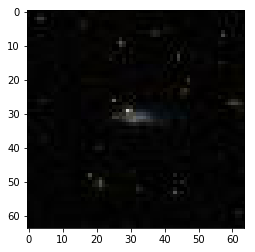

In [3]:
i = 53
print labels_[1][i]
plt.imshow(images_[i])

(array([3220., 2460., 2532., 3296., 3188., 4936., 4940., 5692., 5208.,
        7552.]),
 array([51. , 54.9, 58.8, 62.7, 66.6, 70.5, 74.4, 78.3, 82.2, 86.1, 90. ]),
 <a list of 10 Patch objects>)

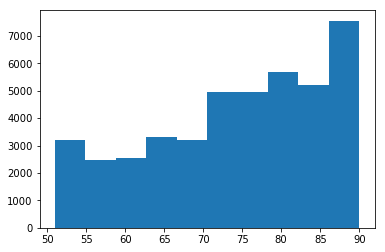

In [4]:
plt.hist(labels_[1][labels_[1]>50])

(60468, 64, 64, 3)
(43024, 64, 64, 3)
65


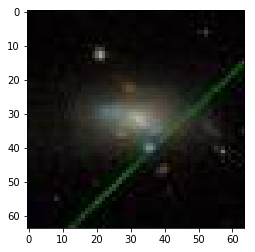

In [5]:
print images_.shape
ix, = np.where(labels_[1]>50)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

print images_c.shape

i = 100
plt.imshow(images_c[i])
print labels_c[i]


In [6]:
print(len(set(labels_c)))
print np.min(labels_c)
print np.max(labels_c)


40
51
90


In [7]:
def esn_shuffle(array, seed=0):
        random.seed(seed)
        random.shuffle(array)
        return array

In [8]:
n = len(labels_c)

indices = np.arange(n)
indices = esn_shuffle(indices, seed=1)


images_cc = images_c[indices]
labels_cc = labels_c[indices]
pgcIDs_cc = pgcIDs_c[indices]

#################

indices = np.arange(1500)
images_test  = images_cc[indices]
labels_test  = labels_cc[indices]
pgcIDs_test  = pgcIDs_cc[indices]

################# 

indices = np.arange(1500, n)
images_train = images_cc[indices]
labels_train = labels_cc[indices]
pgcIDs_train = pgcIDs_cc[indices]


ibx = np.logical_not(np.isin(pgcIDs_train, pgcIDs_test))
images_train = images_train[ibx]
labels_train = labels_train[ibx]
pgcIDs_train = pgcIDs_train[ibx]

#################
# Taking only unique galxies in the test set
# This is the brute-force approach.
# I need to make this better in the future

unique_IDs = []
unique_inx = []

for i, id in enumerate(pgcIDs_test):
    if not id in unique_IDs:
        unique_IDs.append(id)
        unique_inx.append(i)
        
        
images_test  = images_test[unique_inx]
labels_test  = labels_test[unique_inx]
pgcIDs_test  = pgcIDs_test[unique_inx]

images_cvl  = images_test[:1000]
labels_cvl  = labels_test[:1000]
pgcIDs_cvl  = pgcIDs_test[:1000]

images_test  = images_test[1000:]
labels_test  = labels_test[1000:]
pgcIDs_test  = pgcIDs_test[1000:]



In [9]:
print images_train.shape , labels_train.shape
print images_test.shape , labels_test.shape
print images_cvl.shape , labels_cvl.shape

(37352, 64, 64, 3) (37352,)
(418, 64, 64, 3) (418,)
(1000, 64, 64, 3) (1000,)


(array([33., 30., 27., 32., 27., 41., 39., 54., 61., 74.]),
 array([51. , 54.9, 58.8, 62.7, 66.6, 70.5, 74.4, 78.3, 82.2, 86.1, 90. ]),
 <a list of 1 Patch objects>)

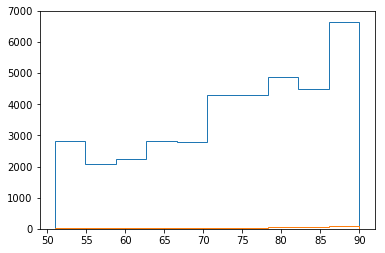

In [10]:
plt.hist(labels_train, histtype='step', label='train')
plt.hist(labels_test, histtype='step', label='test')

In [11]:
print labels_train

[87 63 58 ... 87 89 84]


In [12]:
# labels_train  = labels_train - 51
# labels_test   = labels_test - 51
# images_test   = images_test / 255.
# images_train  = images_train / 255.

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K


# vgg_classify_model = load_model("CNN_inc_VGG6_classify.h5", compile=False)
# vgg_regression_model = load_model("CNN_inc_VGG6_regr.h5", compile=False)
# vgg_regression_model = load_model("CNN_inc_VGG6_regr_01.h5", compile=False)
vgg_regression_model = load_model("CNN_inc_VGG6_regr_seed100.h5", compile=False)


inc_p = vgg_regression_model.predict(images_test)
inc_m = labels_test
N = images_test.shape[0]
inc_p = inc_p.reshape(N)

inc_pc = vgg_regression_model.predict(images_cvl)
inc_mc = labels_cvl
N = images_cvl.shape[0]
inc_pc = inc_pc.reshape(N)

73.58842
75


3377373

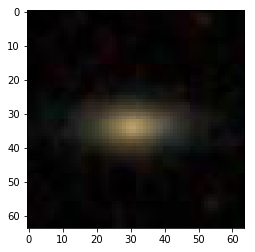

In [47]:
i = 220

print inc_p[i]
print inc_m[i]
plt.imshow(images_test[i])

pgcIDs_test[i]

2.9926384457365365
2.7745715943689087


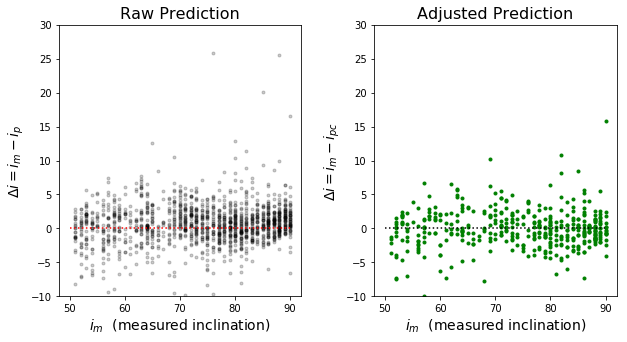

In [36]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p
dc = inc_mc-inc_pc

d = np.concatenate((d,dc))
inc = np.concatenate((inc_m,inc_mc))

m, b = np.polyfit(inc, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc, d, 'k.', alpha=0.2)
ax[0].plot([50,90],[0,0], 'r:')
# ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-10,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print np.sqrt(np.mean((d)**2))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-10,30)

print np.sqrt(np.mean((d_)**2))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

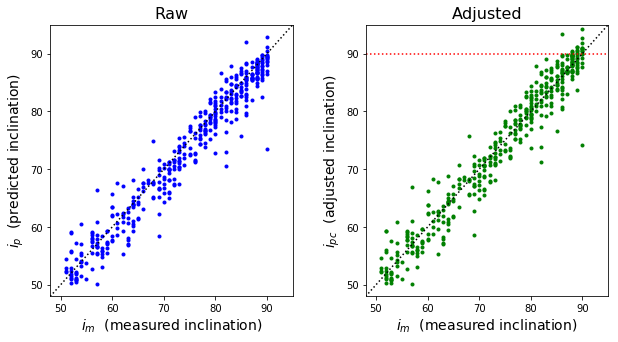

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, 'b.')
ax[0].plot([48,95],[48,95], 'k:')
ax[0].set_xlim(48,95)
ax[0].set_ylim(48,95)
ax[0].set_title('Raw', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

ax[1].plot(inc_m, (inc_p+b)/(1.-m), 'g.')
ax[1].plot([48,95],[48,95], 'k:')
ax[1].set_xlim(48,95)
ax[1].set_ylim(48,95)
ax[1].plot([48,95],[90,90], 'r:')
ax[1].set_title('Adjusted', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)

3.034314874783682
3.026294099394464


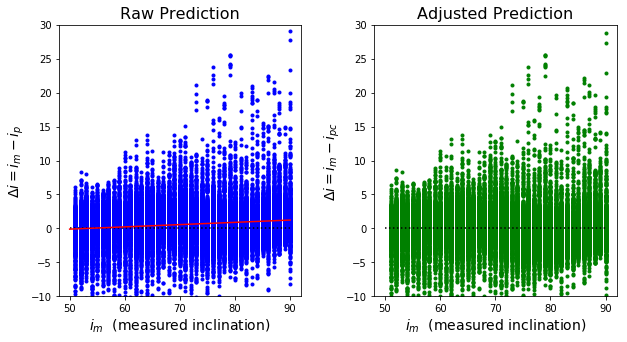

In [19]:
inc_p = vgg_regression_model.predict(images_train)

inc_m = labels_train

N = images_train.shape[0]
inc_p = inc_p.reshape(N)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-10,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print np.sqrt(np.mean((d)**2))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-10,30)

print np.sqrt(np.mean((d_)**2))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

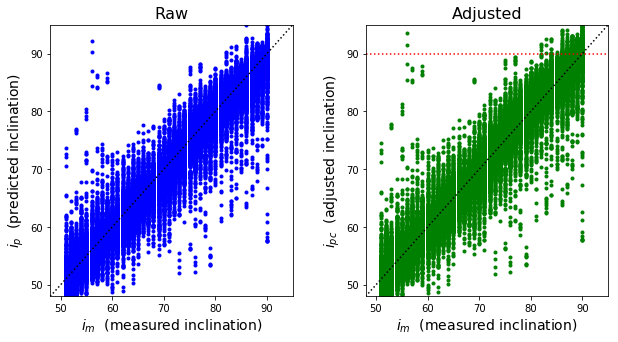

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, 'b.')
ax[0].plot([48,95],[48,95], 'k:')
ax[0].set_xlim(48,95)
ax[0].set_ylim(48,95)
ax[0].set_title('Raw', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)



ax[1].plot(inc_m, (inc_p+b)/(1.-m), 'g.')
ax[1].plot([48,95],[48,95], 'k:')
ax[1].set_xlim(48,95)
ax[1].set_ylim(48,95)
ax[1].plot([48,95],[90,90], 'r:')
ax[1].set_title('Adjusted', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)